In [1]:
import os
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pickle
import sys
from sklearn.neighbors import KernelDensity
sys.path.append('../src')
import P_random
import P_binary
import const as c
from astropy.coordinates import SkyCoord, ICRS, FK5
from astropy import units as u

%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [13]:
AU_to_cm = 1.496e13               # AU to cm
pc_to_cm = 3.086e18               # pc to cm

In [2]:
folder = '../data/TGAS/'

TGAS = np.genfromtxt(open(folder + 'gaia_wide_binaries_TGAS_plx_empirical_cleaned.txt', 'rb'), comments='^', names=True)

TGAS_good = TGAS[TGAS['P_posterior'] > 0.9]

In [3]:
print TGAS.shape
print TGAS_good.shape
print TGAS.dtype

(15677,)
(6806,)
[('P_posterior', '<f8'), ('theta', '<f8'), ('source_ID_1', '<f8'), ('TYC_ID_1', '<f8'), ('HIP_ID_1', '<f8'), ('ra_1', '<f8'), ('dec_1', '<f8'), ('mu_ra_1', '<f8'), ('mu_dec_1', '<f8'), ('mu_ra_err_1', '<f8'), ('mu_dec_err_1', '<f8'), ('plx_1', '<f8'), ('plx_err_1', '<f8'), ('gaia_g_flux_1', '<f8'), ('gaia_g_flux_err_1', '<f8'), ('gaia_g_mag_1', '<f8'), ('2MASS_ID_1', '<f8'), ('2MASS_angle_dist_1', '<f8'), ('2MASS_n_neighbours_1', '<f8'), ('2MASS_n_mates_1', '<f8'), ('2MASS_ph_qual_1', '<f8'), ('2MASS_ra_1', '<f8'), ('2MASS_dec_1', '<f8'), ('2MASS_j_mag_1', '<f8'), ('2MASS_j_mag_err_1', '<f8'), ('2MASS_h_mag_1', '<f8'), ('2MASS_h_mag_err_1', '<f8'), ('2MASS_ks_mag_1', '<f8'), ('2MASS_ks_mag_err_1', '<f8'), ('Tycho_Vt_1', '<f8'), ('Tycho_Vt_err_1', '<f8'), ('Tycho_Bt_1', '<f8'), ('Tycho_Bt_err_1', '<f8'), ('Gaia_delta_Q_1', '<f8'), ('Gaia_noise_1', '<f8'), ('source_ID_2', '<f8'), ('TYC_ID_2', '<f8'), ('HIP_ID_2', '<f8'), ('ra_2', '<f8'), ('dec_2', '<f8'), ('mu_ra_2', '<f

In [15]:
TGAS_300pc = TGAS_good[TGAS_good['plx_1'] > 1.0e3/300.0]
TGAS_200pc = TGAS_good[TGAS_good['plx_1'] > 1.0e3/200.0]
TGAS_100pc = TGAS_good[TGAS_good['plx_1'] > 1.0e3/100.0]

### First, let's look at the distribution of posterior probabilities

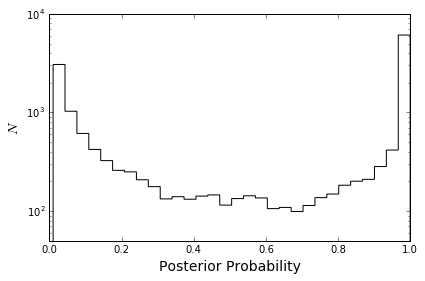

In [85]:
plt.hist(TGAS['P_posterior'], bins=30, linestyle='solid', histtype='step', color='k', log=True)


plt.xlabel('Posterior Probability', fontsize=14)
plt.ylabel(r'$N$', fontsize=14)
#plt.xlabel(r'$P\ (C_2 | \vec{x}_i, \vec{x}_j)$', fontsize=14)

plt.ylim(5.0e1, 1.0e4)

plt.tight_layout()
plt.savefig('../figures/TGAS_P_posterior_dist.pdf')
#plt.show()

### Now, the distance distribution

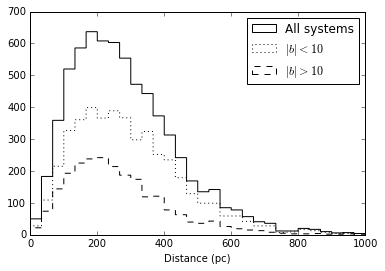

In [57]:

# Determine pairs in halo and in Galactic plane
coor_icrs = SkyCoord(ra=TGAS_good['ra_1']*u.degree, dec=TGAS_good['dec_1']*u.degree, frame='icrs')
idx_plane = np.where(abs(coor_icrs.galactic.b.degree < 10.0))
idx_halo = np.where(abs(coor_icrs.galactic.b.degree >= 10.0))

# Plot different pairs
plt.hist(2.0e3/(TGAS_good['plx_1'] + TGAS_good['plx_2']), histtype='step', color='k', bins=30, 
         range=(0, 1000), label='All systems')
plt.hist(2.0e3/(TGAS_good['plx_1'][idx_plane] + TGAS_good['plx_2'][idx_plane]), histtype='step', color='k', bins=30, 
         range=(0, 1000), linestyle='dotted', label=r'$|b|<10$')
plt.hist(2.0e3/(TGAS_good['plx_1'][idx_halo] + TGAS_good['plx_2'][idx_halo]), histtype='step', color='k', bins=30, 
         range=(0, 1000), linestyle='dashed', label=r'$|b|>10$')

plt.xlabel('Distance (pc)')

plt.legend()

plt.show()

### Now, let's look at the angular separation distribution

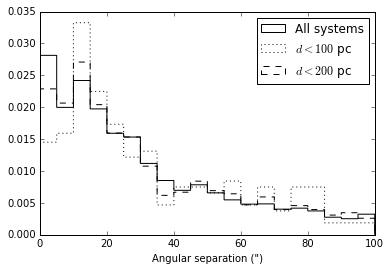

In [65]:
xmin, xmax = 0.0, 100.0

plt.hist(TGAS_good['theta'], histtype='step', color='k', linestyle='solid', bins=20, 
         range=(xmin,xmax), normed=True, label='All systems')
plt.hist(TGAS_100pc['theta'], histtype='step', color='k', linestyle='dotted', bins=20, 
         range=(xmin,xmax), normed=True, label=r'$d<100$ pc')
plt.hist(TGAS_200pc['theta'], histtype='step', color='k', linestyle='dashed', bins=20, 
         range=(xmin,xmax), normed=True, label=r'$d<200$ pc')

plt.xlim(xmin, xmax)
plt.legend()
plt.xlabel('Angular separation (")')
# plt.ylim(0,5)

plt.show()

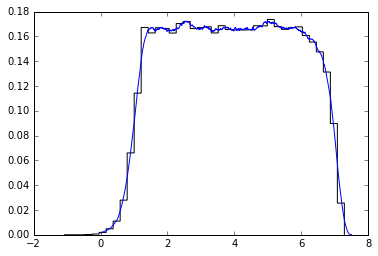

In [67]:
P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='log_flat')

plt.hist(np.log10(P_binary.binary_set['proj_sep']), histtype='step', color='k', bins=40, normed=True)

kwargs = {'kernel':'tophat'}
proj_sep_kde = KernelDensity(bandwidth=0.2, **kwargs)
proj_sep_kde.fit( np.log10(P_binary.binary_set['proj_sep'][:, np.newaxis] ))


#print np.exp(proj_sep_kde.score_samples(plx[:, np.newaxis]))

sep = np.linspace(0.0, 7.5, 1000)
prob_sep = np.exp(proj_sep_kde.score_samples(sep[:, np.newaxis]))

plt.plot(sep, prob_sep)
#plt.ylim(0.0, 1.0e-3)

plt.show()

In [66]:
def get_integrand(dist, angle, dist_max):
    """ Integrand. Distance in pc, angle in asec """
    
    proj_sep = (angle/3600.0*np.pi/180.0) * (dist*c.pc_to_cm/c.Rsun_to_cm)
        
    prob_proj_sep = np.exp(proj_sep_kde.score_samples(np.log10(proj_sep*np.ones(1)[:, np.newaxis]))) / (proj_sep*np.log(10.))
    
    return prob_proj_sep * 3.0 * dist**3 * dist_max**(-3)

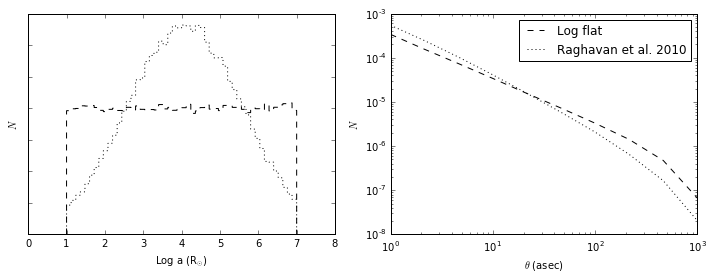

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

dist_min = 1.0
nsamples = 10
xmin = 1.0
xmax = 1000.0

log_angles = np.linspace(np.log10(xmin), np.log10(xmax), nsamples)
angles = 10**log_angles




# Flat in log-space, thermal e
P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='log_flat')

tmp_a = P_binary.get_a(num_sys=100000, prob='log_flat')
ax[0].hist(np.log10(tmp_a), histtype='step', color='k', bins=50, linestyle='dashed', label='Log flat')

proj_sep_kde is None
kwargs = {'kernel':'tophat'}
proj_sep_kde = KernelDensity(bandwidth=0.2, **kwargs)
proj_sep_kde.fit( np.log10(P_binary.binary_set['proj_sep'][:, np.newaxis] ))


P_theta = np.zeros(nsamples)
dist_max = 100.0
for i, ang in zip(np.arange(nsamples), angles):
    args = ang, dist_max
    P_theta[i], err_theta = quad(get_integrand, dist_min, dist_max, args=args)

ax[1].plot(angles, P_theta, color='k', linestyle='dashed', label='Log flat')






# Log-normal, thermal e
P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='raghavan')

tmp_a = P_binary.get_a(num_sys=100000, prob='raghavan')
ax[0].hist(np.log10(tmp_a), histtype='step', color='k', bins=50, linestyle='dotted', label='Raghavan et al. 2010')

proj_sep_kde is None
kwargs = {'kernel':'tophat'}
proj_sep_kde = KernelDensity(bandwidth=0.2, **kwargs)
proj_sep_kde.fit( np.log10(P_binary.binary_set['proj_sep'][:, np.newaxis] ))


P_theta = np.zeros(nsamples)
dist_max = 100.0
for i, ang in zip(np.arange(nsamples), angles):
    args = ang, dist_max
    P_theta[i], err_theta = quad(get_integrand, dist_min, dist_max, args=args)

ax[1].plot(angles, P_theta, color='k', linestyle='dotted', label='Raghavan et al. 2010')



ax[0].set_xlim(0, 8)
ax[0].set_xlabel(r'Log a (R$_{\odot}$)')
ax[0].set_ylabel(r'$N$')
ax[0].set_yticklabels([])


ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_xlim(xmin, xmax)
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\theta$ (asec)')
ax[1].set_ylabel(r'$N$')
#ax[1].set_yticklabels([])

plt.tight_layout()
#plt.savefig('../figures/proj_sep_dist.pdf')
plt.show()

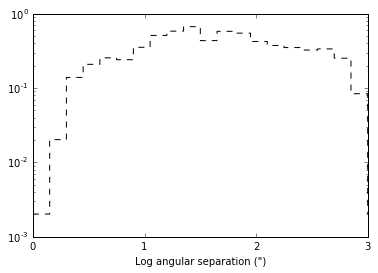

In [95]:
xmin, xmax = 0, 3


plt.hist(np.log10(TGAS_200pc['theta']), histtype='step', color='k', linestyle='dashed', bins=20, 
         range=(xmin,xmax), normed=True, label=r'$d<200$ pc', log=True)

plt.xlabel('Log angular separation (")')
plt.xticks([0, 1, 2, 3])


plt.show()

In [109]:
folder = '../data/TGAS/'

TGAS_new = np.genfromtxt(open(folder + 'gaia_wide_binaries_TGAS_plx_empirical_cleaned.txt', 'rb'), comments='^', names=True)
TGAS_old = np.genfromtxt(open(folder + 'gaia_wide_binaries_TGAS_plx_empirical.txt', 'rb'), names=True, skip_header=4)

In [131]:
dtype = [('source_id_1','<i8'),('source_id_2','<i8'),('P_posterior_1','f8'),('P_posterior_2','f8'),
         ('idx_1','i8'), ('idx_2','i8')]
compare = np.zeros(len(TGAS_new), dtype=dtype)
compare_zero = np.zeros(1, dtype=dtype)

compare['source_id_1'] = TGAS_new['source_ID_1']
compare['source_id_2'] = TGAS_new['source_ID_2']
compare['P_posterior_1'] = TGAS_new['P_posterior']
compare['idx_1'] = np.arange(len(TGAS_new))
compare['idx_2'] = -1* np.ones(len(TGAS_new))



for i in np.arange(len(TGAS_old)):
#for i in np.arange(40):
    idx1 = np.where(TGAS_old[i]['source_ID_1'] == compare['source_id_1']) 

    if len(idx1[0]) < 1: 
        compare = np.append(compare, compare_zero)
        compare[-1]['source_id_1'] = TGAS_old['source_ID_1'][i]
        compare[-1]['source_id_2'] = TGAS_old['source_ID_2'][i]
        compare[-1]['P_posterior_2'] = TGAS_old['P_posterior'][i]
        compare[-1]['idx_1'] = -1
        compare[-1]['idx_2'] = i
        continue

    j_good = -1

    for j in idx1[0]:
        if TGAS_old[i]['source_ID_2'] == compare[j]['source_id_2']:
            j_good = j

    if j_good == -1:
        compare = np.append(compare, compare_zero)
        compare[-1]['source_id_1'] = TGAS_old['source_ID_1'][i]
        compare[-1]['source_id_2'] = TGAS_old['source_ID_2'][i]
        compare[-1]['P_posterior_2'] = TGAS_old['P_posterior'][i]
        compare[-1]['idx_1'] = -1
        compare[-1]['idx_2'] = i
    else:
        compare[j_good]['P_posterior_2'] = TGAS_old['P_posterior'][i]
        compare[j_good]['idx_2'] = i




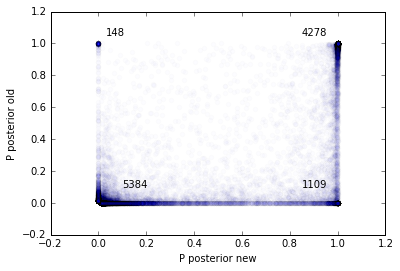

In [134]:
plt.scatter(compare['P_posterior_1'], compare['P_posterior_2'], alpha=0.01)

plt.xlabel('P posterior new')
plt.ylabel('P posterior old')

# Print numbers at bottom right and top left
idx_bottom_left = 0
idx_bottom_right = 0
idx_top_left = 0
idx_top_right = 0

for i in np.arange(len(compare)):
    
    if compare[i]['P_posterior_1'] > 0.9 and compare[i]['P_posterior_2'] > 0.9: 
        idx_top_right = np.append(idx_top_right, i)
    if compare[i]['P_posterior_1'] > 0.9 and compare[i]['P_posterior_2'] < 0.1: 
        idx_bottom_right = np.append(idx_bottom_right, i)
    if compare[i]['P_posterior_1'] < 0.1 and compare[i]['P_posterior_2'] > 0.9: 
        idx_top_left = np.append(idx_top_left, i)
    if compare[i]['P_posterior_1'] < 0.1 and compare[i]['P_posterior_2'] < 0.1: 
        idx_bottom_left = np.append(idx_bottom_left, i)

        
plt.text(0.85, 0.1, len(idx_bottom_right))
plt.text(0.1, 0.1, len(idx_bottom_left))
plt.text(0.03, 1.05, len(idx_top_left))
plt.text(0.85, 1.05, len(idx_top_right))


plt.show()

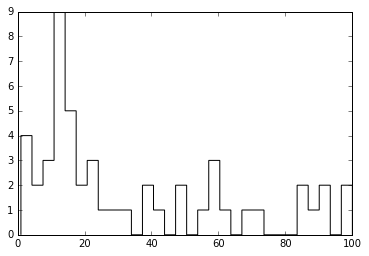

In [163]:
plt.hist(TGAS_old['theta'][compare['idx_2'][idx_top_left]], histtype='step', color='k', bins=30, range=(1, 100))
#plt.hist(TGAS_new['theta'][compare['idx_1'][compare['idx_1'] != -1]], histtype='step', color='k', bins=30, range=(1, 100))

plt.show()

In [162]:
for i in np.arange(len(compare[idx_top_left])):
    print TGAS_old['ra_1'][compare['idx_2'][idx_top_left][i]], TGAS_old['dec_1'][compare['idx_2'][idx_top_left][i]], \
        TGAS_old['ra_2'][compare['idx_2'][idx_top_left][i]], TGAS_old['dec_2'][compare['idx_2'][idx_top_left][i]]

35.757832713 -23.124378481 35.756979104 -23.120035192
27.756144779 60.009233803 27.762469971 60.00694653
26.64805941 61.26328309 26.643889218 61.26249717
193.422177641 -60.349438726 193.406707397 -60.357066696
135.42001554 -43.478532545 135.461289374 -43.420651574
196.91425686 24.010428775 196.918535796 24.020537249
184.829914124 23.034632418 184.650692275 23.120039593
162.578260128 22.569365 162.592284584 22.566312559
187.08790255 28.040542157 186.951164703 28.194376023
268.445837272 -34.846377327 268.492252488 -34.831079466
270.237265007 -34.96495675 270.240372568 -34.966472941
160.58354325 24.272801209 160.597033441 24.303949723
117.160811459 -63.688820491 117.163700406 -63.691618367
119.187897429 -60.81503214 119.192720708 -60.816145345
119.008323582 -60.257462384 119.02007545 -60.242651769
118.573629017 -57.186907625 118.564547613 -57.188587
118.564547613 -57.188587 118.481015371 -57.168598014
135.186318541 -57.69275435 134.972845167 -57.791583605
130.344580552 -53.6357772 130.204

In [23]:
# Calculate distance from average parallaxes, weighted by uncertainties
dist = np.zeros(len(TGAS_good))
for i in np.arange(len(TGAS_good)):
    vals = [TGAS_good['plx_1'][i],TGAS_good['plx_2'][i]]
    weights = [1.0/TGAS_good['plx_err_1'][i]**2,1.0/TGAS_good['plx_err_2'][i]**2]
    dist[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s = (TGAS_good['theta']*np.pi/180.0/3600.0) * dist * (pc_to_cm/AU_to_cm)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in log10


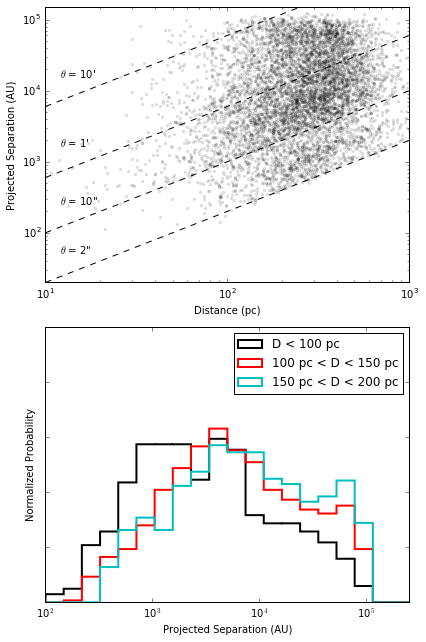

In [97]:
fig, ax = plt.subplots(2, 1, figsize=(6, 9))


tmp_x = 10**np.linspace(1,3,100)
#tmp_y_1as = (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_2as = 2. * (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_10as = 10. * (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_60as = 60. * (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_600as = 600. * (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)

ax[0].scatter(dist, s, marker='.', color='k', alpha=0.1, rasterized=True)

#plt.plot(tmp_x, tmp_y_1as, color='k', linestyle='dashed')
ax[0].plot(tmp_x, tmp_y_2as, color='k', linestyle='dashed')
ax[0].text(12.0, 50., r'$\theta$ = 2"')
ax[0].plot(tmp_x, tmp_y_10as, color='k', linestyle='dashed')
ax[0].text(12.0, 250., r'$\theta$ = 10"')
ax[0].plot(tmp_x, tmp_y_60as, color='k', linestyle='dashed')
ax[0].text(12.0, 1600., r"$\theta$ = 1'")
ax[0].plot(tmp_x, tmp_y_600as, color='k', linestyle='dashed')
ax[0].text(12.0, 15000., r"$\theta$ = 10'")



ax[0].set_xlim(10.0, 1000.0)
ax[0].set_ylim(20.0, 1.5e5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("Distance (pc)")
ax[0].set_ylabel("Projected Separation (AU)")



idx_100 = np.where(dist<100.0)
idx_100_150 = np.intersect1d(np.where(dist<150.0)[0], np.where(dist>100.0)[0])
idx_150_200 = np.intersect1d(np.where(dist<200.0)[0], np.where(dist>150.0)[0])


xmin, xmax = 2.0, 5.4
ax[1].hist( np.log10(s[idx_100]), histtype='step', normed=True, linewidth=2.0,
           color='k', bins=20, range=(xmin,xmax), label='D < 100 pc')
ax[1].hist( np.log10(s[idx_100_150]), histtype='step', normed=True, linewidth=2.0, 
           color='r', bins=20, range=(xmin,xmax), label='100 pc < D < 150 pc')
ax[1].hist( np.log10(s[idx_150_200]), histtype='step', normed=True, linewidth=2.0, 
           color='c', bins=20, range=(xmin,xmax), label='150 pc < D < 200 pc')
ax[1].set_xlabel("Projected Separation (AU)")
ax[1].set_ylabel('Normalized Probability')
ax[1].set_xticks([1, 2, 3, 4, 5])
ax[1].set_xticklabels([r'10$^1$', r'10$^2$', r'10$^3$', r'10$^4$', r'10$^5$'])
ax[1].set_yticklabels([])

ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(0, 1.)
ax[1].legend(loc=1)

plt.tight_layout()
plt.savefig('../figures/TGAS_s_distribution.pdf')
#plt.show()

In [99]:
print 10.*pc_to_cm / 6.95e10

444028776.978
